In [35]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import SGD
from torchvision.transforms import ToTensor

## Creating the model

In [10]:
class my_first_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            # Primera capa que pasa de una imagen 28*28 a 512 hidden layers
            nn.ReLU(),
            #Función de activación 
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

In [14]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100.0%
100.0%
100.0%
100.0%


c:\Users\steve\OneDrive\Desktop\Tesis\.venv\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


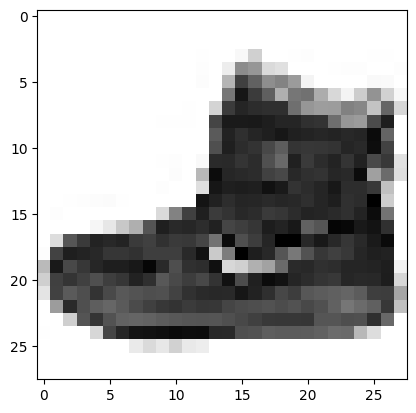

In [21]:
import matplotlib.pyplot as plt

plt.imshow(training_data.train_data[0], cmap='Greys')

In [37]:
model = my_first_network()
data = training_data.train_data.to(torch.float32)
labels = training_data.train_labels.to(torch.float32)

In [39]:
model.forward(data[0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 784x512)

In [46]:
x = nn.Flatten(data[0])

type(x)

torch.nn.modules.flatten.Flatten